# Text classification with Neural Networks
In this jupyter notebook, I will employ several strategies to train a deep learning neural network for text classification task, including:
- A binary classification task with movie reviews dataset
  - a densly connected NN with multi-hot encoding
  - a bidirectional LSTM with self-trained embedding
  - a bidirectional LSTM with pre-trained embedding

## A binary text classification example with dating app

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import classification_report

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [ ]:
# mount
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/cleaned_okc.csv"

df = pd.read_csv(path)
df.shape

(38384, 33)

In [ ]:
df.head()

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,"Favorite books, movies, show, music, and food",The six things I could never do without,I spend a lot of time thinking about,On a typical Friday night I am,The most private thing I am willing to admit,You should message me if…,merged_profile,cleaned_religion,seriousness_degree,belief
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,"books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...,about me: i would love to think that i was so...,agnosticism,4.0,agnosticism
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN,i am a chef: this is what that means. 1. i am ...,agnosticism,2.0,agnosticism
2,29,single,m,straight,average,mostly anything,socially,NaN,graduated from college/university,white,...,"books: to kill a mockingbird, lord of the ring...","like everyone else, i love my friends and fami...",what my contribution to the world is going to ...,out with my friends!,i cried on my first day at school because a bi...,you're awesome.,"i'm an australian living in san francisco, but...",atheism,0.0,atheism
3,31,single,f,straight,average,mostly anything,socially,never,graduated from college/university,white,...,"i like: alphabetized lists, aquariums, autobio...","friends, family, notebook/pen, books, music, t...",things that amuse and inspire me,out and about or relaxing at home with a good ...,NaN,NaN,"writing. meeting new people, spending time wi...",christianity,0.0,theism
4,24,single,f,straight,NaN,strictly anything,socially,NaN,graduated from college/university,white,...,i am always willing to try new foods and am no...,sports/my softball glove coffee. because nobod...,NaN,"in or out... drinking with friends, maybe a ba...",potential friends/lovers/people who come in co...,http://www.youtube.com/watch?v=4dxbwzuwsxk let...,"oh goodness. at the moment i have 4 jobs, so ...",christianity,2.0,theism


In [ ]:
# There are 4 type of beliefs in the dataset
df.belief.value_counts()

theism         15519
agnosticism     8583
other           7492
atheism         6790
Name: belief, dtype: int64

In [ ]:
# filtered the dataset to only include theism and atheism
df_filtered = df[df['belief'].isin(['theism', 'atheism'])].copy()

# belief as binary variable. 0: atheism, 1: theism
df_filtered['belief'] = df_filtered['belief'].map({'theism': 1, 'atheism': 0})

df = df_filtered

df.shape

(22309, 33)

In [ ]:
df.columns

Index(['age', 'status', 'sex', 'orientation', 'body_type', 'diet', 'drinks',
       'drugs', 'education', 'ethnicity', 'height', 'income', 'job',
       'location', 'offspring', 'pets', 'sign', 'smokes', 'speaks',
       'My self summary', 'What I’m doing with my life', 'I’m really good at',
       'The first thing people usually notice about me',
       'Favorite books, movies, show, music, and food',
       'The six things I could never do without',
       'I spend a lot of time thinking about',
       'On a typical Friday night I am',
       'The most private thing I am willing to admit',
       'You should message me if…', 'merged_profile', 'cleaned_religion',
       'seriousness_degree', 'belief'],
      dtype='object')

### Train a densly connected NN with multi-hot encoding
**Text vectorization with multi-hot encoding**

I will use "My self summary", because it is closest to self-description.

In [ ]:
df["My self summary"].isna().sum()


1225

In [ ]:
# drop empty rows
df = df[df["My self summary"].notna()]

# make sure it's in str format
df['My self summary'] = df['My self summary'].astype(str)

df.shape

(21084, 33)

In [ ]:
max_length = 600
max_tokens = 20000
vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="multi_hot", # try "int", "count", "multi_hot", "tf_idf"
    # output_sequence_length=max_length,
)
vectorizer.adapt(df['My self summary'])
vectorized_text = vectorizer(df['My self summary'])

In [ ]:
# an example of the vectorized text
vectorized_text[0]

<tf.Tensor: shape=(20000,), dtype=float32, numpy=array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)>

In [ ]:
vocab = vectorizer.get_vocabulary()
type(vocab), len(vocab)

(list, 20000)

In [ ]:
def decode_text(multi_hot_vec, vectorizer):
  """
  Decode indices back to text
  Note that: there's no order information in the decoded text
  """
  indices = np.where(multi_hot_vec == 1)[0]
  vocab = vectorizer.get_vocabulary()
  words = [vocab[index] for index in indices]
  return ' '.join(words)
  # vocab = vectorizer.get_vocabulary()
  # return ' '.join(vocab[i] for i in indices)

In [ ]:
decode_text(vectorized_text[0], vectorizer)

'[UNK] i and to a the in of my im for am that have but me love like it on at out people who about so are can an just if new things do this dont enjoy more what someone really fun been myself think most pretty find san francisco something because them laugh little trying which living sf sometimes doing only funny spend often look stuff else days company cool everyone laughing speak hold seems known gets occasionally teach parties build wild intelligence trouble against asked chinese karaoke songs reasons equal turns meant entrepreneur imagination measure mandarin downtime australian bust cheeky oddball improbable'

**Split the data into train/test/validation**

In [ ]:
X_train = vectorized_text[:15616]
y_train = df.belief.values[:15616]

X_val = vectorized_text[15616:15616+3346]
y_val = df.belief.values[15616:15616+3346]

X_test = vectorized_text[15616+3346:]
y_test = df.belief.values[15616+3346:]

X_train.shape, X_test.shape, X_val.shape


(TensorShape([15616, 20000]),
 TensorShape([2122, 20000]),
 TensorShape([3346, 20000]))

**Build, compile, and train a densly connected NN**

In [ ]:
# create the model
ds_model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [ ]:
# compile the model
ds_model.compile(optimizer="rmsprop",
                 loss="binary_crossentropy",
                 metrics=["accuracy"])

In [ ]:
# train the model
ds_history = ds_model.fit(X_train, y_train, epochs=20, batch_size=512,
                          validation_data=(X_val, y_val))

Epoch 1/20
31/31 [==============================] - 3s 80ms/step - loss: 0.6068 - accuracy: 0.6834 - val_loss: 0.5662 - val_accuracy: 0.6978
Epoch 2/20
31/31 [==============================] - 2s 72ms/step - loss: 0.5323 - accuracy: 0.7250 - val_loss: 0.5388 - val_accuracy: 0.7241
Epoch 3/20
31/31 [==============================] - 3s 104ms/step - loss: 0.4793 - accuracy: 0.7729 - val_loss: 0.5390 - val_accuracy: 0.7212
Epoch 4/20
31/31 [==============================] - 3s 90ms/step - loss: 0.4368 - accuracy: 0.8009 - val_loss: 0.5476 - val_accuracy: 0.7224
Epoch 5/20
31/31 [==============================] - 2s 73ms/step - loss: 0.4013 - accuracy: 0.8260 - val_loss: 0.5645 - val_accuracy: 0.7212
Epoch 6/20
31/31 [==============================] - 2s 73ms/step - loss: 0.3675 - accuracy: 0.8468 - val_loss: 0.5741 - val_accuracy: 0.7230
Epoch 7/20
31/31 [==============================] - 2s 73ms/step - loss: 0.3391 - accuracy: 0.8616 - val_loss: 0.6075 - val_accuracy: 0.7065
Epoch 8/20
3

**Evaluate model performance**

In [ ]:
# evaluate model performance regarding accuracy
test_loss, test_acc = ds_model.evaluate(X_test, y_test)
print(f"test_acc: {np.round(test_acc,3)}")

67/67 [==============================] - 0s 3ms/step - loss: 1.0319 - accuracy: 0.7290
test_acc: 0.729


In [ ]:
# print other evaluation metrics
predict_probs = ds_model.predict(X_test)
y_pred = (predict_probs > 0.5).astype(int)
print(classification_report(y_test, y_pred))

67/67 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.54      0.38      0.45       610
           1       0.78      0.87      0.82      1512

    accuracy                           0.73      2122
   macro avg       0.66      0.63      0.63      2122
weighted avg       0.71      0.73      0.71      2122



**Visualize model performance during training**

In [ ]:
def visualize_performance(history, flag):
  history_dict = history.history
  epochs = range(1, len(history_dict["loss"]) + 1)

  plt.plot(epochs, history_dict[flag], "bo", label="Training "+flag)
  plt.plot(epochs, history_dict["val_"+flag], "b", label="Validation "+flag)
  plt.title("Training and validation "+flag)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

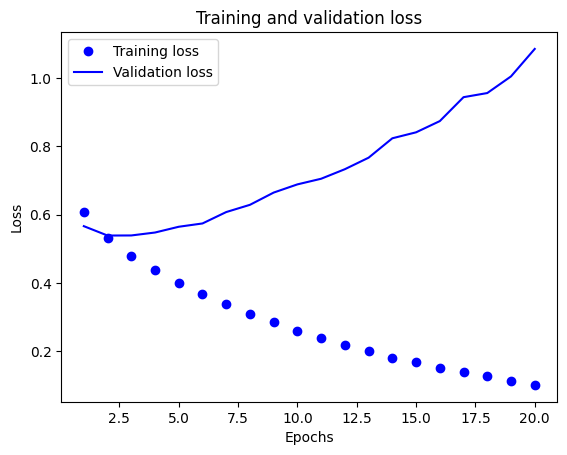

In [ ]:
visualize_performance(ds_history, flag = 'loss')

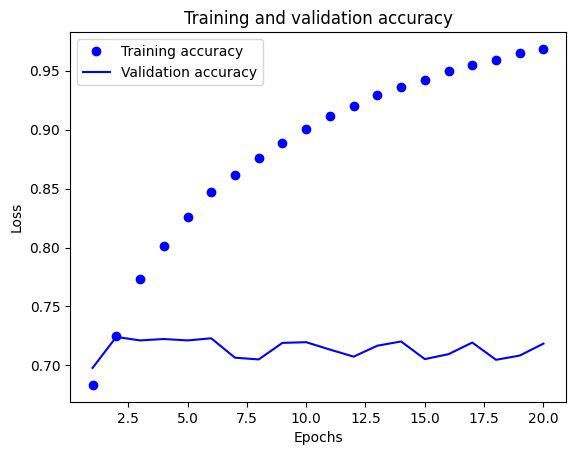

In [ ]:
visualize_performance(ds_history, flag = 'accuracy')

### Model Evaluation Findings

After evaluating the model on the test set, several key observations can be made regarding its performance:

1. **Class Imbalance**: The model performs significantly better on class 1 compared to class 0. This suggests a class imbalance in the dataset, where samples of class 1 are much more abundant than those of class 0. Class imbalance can lead to the model being biased towards the majority class, resulting in poor performance on the minority class.

2. **Recall Issue**: The recall for class 0 is relatively low, indicating that the model fails to identify a significant number of actual class 0 samples. In certain applications, such as disease diagnosis or fraud detection, a low recall could have serious implications.

3. **Overall Model Performance**: While the model's overall accuracy is acceptable, there is room for improvement in terms of the macro and weighted average F1 scores.

### Solutions to Improve Model Performance


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# use SMOTE to address data imblance without affecting original data distribution
smote = SMOTE()
X_res, y_res = smote.fit_resample(X_train, y_train)

# X_res, y_res


In [ ]:
# train the model
ds_history = ds_model.fit(X_res, y_res, epochs=20, batch_size=512,
                          validation_data=(X_val, y_val))

Epoch 1/20
43/43 [==============================] - 3s 69ms/step - loss: 0.1464 - accuracy: 0.9483 - val_loss: 1.1439 - val_accuracy: 0.6733
Epoch 2/20
43/43 [==============================] - 3s 68ms/step - loss: 0.1162 - accuracy: 0.9659 - val_loss: 1.2080 - val_accuracy: 0.6949
Epoch 3/20
43/43 [==============================] - 5s 124ms/step - loss: 0.0985 - accuracy: 0.9722 - val_loss: 1.3337 - val_accuracy: 0.7053
Epoch 4/20
43/43 [==============================] - 5s 110ms/step - loss: 0.0892 - accuracy: 0.9753 - val_loss: 1.3761 - val_accuracy: 0.6898
Epoch 5/20
43/43 [==============================] - 5s 107ms/step - loss: 0.0792 - accuracy: 0.9781 - val_loss: 1.4659 - val_accuracy: 0.6817
Epoch 6/20
43/43 [==============================] - 5s 110ms/step - loss: 0.0682 - accuracy: 0.9803 - val_loss: 1.5440 - val_accuracy: 0.6886
Epoch 7/20
43/43 [==============================] - 4s 96ms/step - loss: 0.0656 - accuracy: 0.9807 - val_loss: 1.6162 - val_accuracy: 0.6799
Epoch 8/2

In [ ]:
# evaluate model performance regarding accuracy
test_loss, test_acc = ds_model.evaluate(X_test, y_test)
print(f"test_acc: {np.round(test_acc,3)}")

67/67 [==============================] - 1s 7ms/step - loss: 2.6158 - accuracy: 0.6621
test_acc: 0.662


In [ ]:
# print other evaluation metrics
predict_probs = ds_model.predict(X_test)
y_pred = (predict_probs > 0.5).astype(int)
print(classification_report(y_test, y_pred))

67/67 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.44      0.60      0.51       610
           1       0.81      0.69      0.74      1512

    accuracy                           0.66      2122
   macro avg       0.62      0.64      0.62      2122
weighted avg       0.70      0.66      0.67      2122



Although the performance dropped from 72.9 to 66.2 (acc in %). However, this tuned model is closer to authentic performance

### Train a bidirectional LSTM with self-trained embedding

**Vectorize text to a sequence of indices**

In [ ]:
max_length = 600
max_tokens = 20000
vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
vectorizer.adapt(df['My self summary'])
vectorized_text = vectorizer(df['My self summary'])

In [ ]:
# an example of the vectorized text
vectorized_text[0]

<tf.Tensor: shape=(600,), dtype=int64, numpy=
array([   10,    37,  4769,   137,     7,   101,   120,    17,    49,
         622,    14,  1340,    18,     2,   198,    86,     8,     9,
         296,   132,     4,   873,   341,   258,    11,     9,   326,
           2,   580,  4219,     3,    16,    67,   730,     4,  5095,
          30,  1437,  1501,    27,  1472,    10,    91,  7617,    61,
        1432,    18,    39,    14,  1839,   121,    33,     9,     1,
         135,     2,    93,    62,   189,    10,     5,   128,  9443,
           2,    16,     5,  1038,  2213,     2,    20,     4,    80,
           8,     6,    86, 11382,  1549,    31,    35,   171,    43,
          38,    11,    65,     2,    19,     4,   127,     3,   245,
          11,  1549,     4,    44,    34,   765,    48,   745,    18,
           7,  1294,   122,    31,    80,    10,   490,    27,   126,
         159,     2,    12,    17,    52,   225,    10,   173,   490,
          27,    68,    10,    37,  1889,   

In [ ]:
def decode_text_seq(indices, vectorizer):
  """
  Decode indices back to text
  """
  vocab = vectorizer.get_vocabulary()
  return ' '.join(vocab[i] for i in indices)

In [ ]:
# an example of the decoded text
decode_text_seq(vectorized_text[0], vectorizer)

'im an australian living in san francisco but dont hold that against me i spend most of my days trying to build cool stuff for my company i speak mandarin and have been known to bust out chinese songs at karaoke im pretty cheeky someone asked me if that meant something about my [UNK] which i find really funny im a little oddball i have a wild imagination i like to think of the most improbable reasons people are doing things just for fun i love to laugh and look for reasons to do so occasionally this gets me in trouble because people think im laughing at them sometimes i am but more often im only laughing at myself im an entrepreneur like everyone else in sf it seems and i love what i do i enjoy parties and downtime in equal measure intelligence really turns me on and i love people who can teach me new things                                                                                                                                                                                     

**Split data into train/test/validation**

In [ ]:
# 75,15,15 %


X_train = vectorized_text[:15616]
y_train = df.belief.values[:15616]

X_val = vectorized_text[15616:15616+3346]
y_val = df.belief.values[15616:15616+3346]

X_test = vectorized_text[15616+3346:]
y_test = df.belief.values[15616+3346:]

X_train.shape, X_test.shape, X_val.shape


(TensorShape([15616, 600]), TensorShape([2122, 600]), TensorShape([3346, 600]))

**Build,compile, and train a bidirectional LSTM with a embedding layer**

In [ ]:
# create the embedding layer
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs) # try mask_zero=True

In [ ]:
# build a bidirectional LSTM
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

eb_model = keras.Model(inputs, outputs)
eb_model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
eb_model.summary()

# callbacks = [
#     keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
#                                     save_best_only=True)
# ]
# model.fit(X_train, y_train, validation_data=int_val_ds, epochs=10,
#           callbacks=callbacks)
# model = keras.models.load_model("embeddings_bidir_gru.keras")
# print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 bidirectional (Bidirection  (None, 64)                73984     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5194049 (19.81 MB)
Trainable params: 5194049 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [ ]:
# train the model
eb_history = eb_model.fit(X_train, y_train, epochs=20, batch_size=512,
                          validation_data=(X_val, y_val))

Epoch 1/20
31/31 [==============================] - 216s 7s/step - loss: 0.6276 - accuracy: 0.6805 - val_loss: 0.6176 - val_accuracy: 0.6928
Epoch 2/20
31/31 [==============================] - 212s 7s/step - loss: 0.6178 - accuracy: 0.6908 - val_loss: 0.6108 - val_accuracy: 0.6928
Epoch 3/20
31/31 [==============================] - 205s 7s/step - loss: 0.6103 - accuracy: 0.6908 - val_loss: 0.5920 - val_accuracy: 0.6931
Epoch 4/20
31/31 [==============================] - 207s 7s/step - loss: 0.5951 - accuracy: 0.6901 - val_loss: 0.5777 - val_accuracy: 0.6975
Epoch 5/20
31/31 [==============================] - 208s 7s/step - loss: 0.5763 - accuracy: 0.6982 - val_loss: 0.5637 - val_accuracy: 0.7104
Epoch 6/20
31/31 [==============================] - 206s 7s/step - loss: 0.5644 - accuracy: 0.7070 - val_loss: 0.5547 - val_accuracy: 0.7074
Epoch 7/20
31/31 [==============================] - 205s 7s/step - loss: 0.5475 - accuracy: 0.7197 - val_loss: 0.5488 - val_accuracy: 0.7158
Epoch 8/20
31

**Evaluate model performance**

In [ ]:
# evaluate model performance regarding accuracy
test_loss, test_acc = eb_model.evaluate(X_test, y_test)
print(f"test_acc: {np.round(test_acc,3)}")

67/67 [==============================] - 14s 202ms/step - loss: 0.5931 - accuracy: 0.7191
test_acc: 0.719


In [ ]:
# print other evaluation metrics
predict_probs = eb_model.predict(X_test)
y_pred = (predict_probs > 0.5).astype(int)
print(classification_report(y_test, y_pred))

67/67 [==============================] - 18s 233ms/step
              precision    recall  f1-score   support

           0       0.52      0.33      0.41       610
           1       0.77      0.87      0.82      1512

    accuracy                           0.72      2122
   macro avg       0.64      0.60      0.61      2122
weighted avg       0.69      0.72      0.70      2122



**Visualize model performance during training**

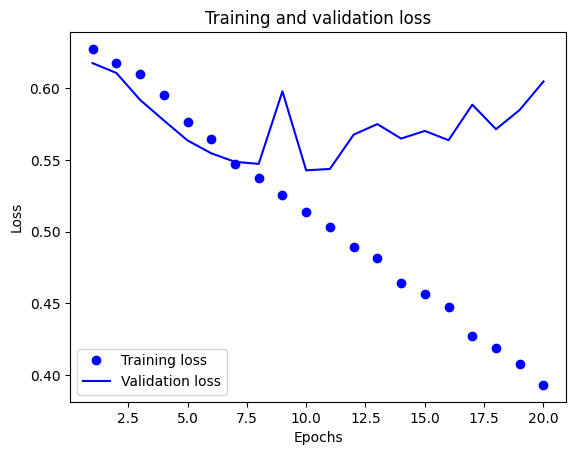

In [ ]:
visualize_performance(eb_history, flag = 'loss')

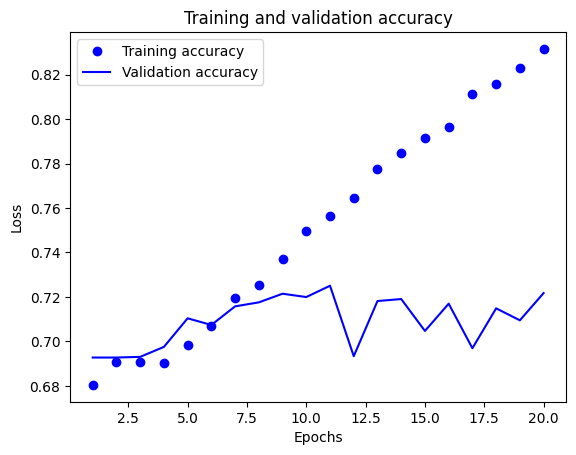

In [ ]:
visualize_performance(eb_history, flag = 'accuracy')

### Train a bidirectional LSTM with pre-trained embedding model

**Get the pre-trained embedding**

In [ ]:
# get the Glove embedding (this takes about 3min)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-03-01 03:53:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-03-01 03:53:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-03-01 03:53:24--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Parse the GloVe word-embeddings file
# build a map from words to vector representations
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [ ]:
# an example of the Glove embedding representation for a word
embeddings_index['love']

array([ 2.5975e-01,  5.5833e-01,  5.7986e-01, -2.1361e-01,  1.3084e-01,
        9.4385e-01, -4.2817e-01, -3.7420e-01, -9.4499e-02, -4.3344e-01,
       -2.0937e-01,  3.4702e-01,  8.2516e-02,  7.9735e-01,  1.6606e-01,
       -2.6878e-01,  5.8830e-01,  6.7397e-01, -4.9965e-01,  1.4764e+00,
        5.5261e-01,  2.5295e-02, -1.6068e-01, -1.3878e-01,  4.8686e-01,
        1.1420e+00,  5.6195e-02, -7.3306e-01,  8.6932e-01, -3.5892e-01,
       -5.1877e-01,  9.0402e-01,  4.9249e-01, -1.4915e-01,  4.8493e-02,
        2.6096e-01,  1.1352e-01,  4.1275e-01,  5.3803e-01, -4.4950e-01,
        8.5733e-02,  9.1184e-02,  5.0177e-03, -3.4645e-01, -1.1058e-01,
       -2.2235e-01, -6.5290e-01, -5.1838e-02,  5.3791e-01, -8.1040e-01,
       -1.8253e-01,  2.4194e-01,  5.4855e-01,  8.7731e-01,  2.2165e-01,
       -2.7124e+00,  4.9405e-01,  4.4703e-01,  5.5882e-01,  2.6076e-01,
        2.3760e-01,  1.0668e+00, -5.6971e-01, -6.4960e-01,  3.3511e-01,
        3.4609e-01,  1.1033e+00,  8.5261e-02,  2.4847e-02, -4.54

In [ ]:
# initialize a vectorizer
max_length = 600
max_tokens = 20000
text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorizer.adapt(df['My self summary'])
vectorized_text = text_vectorizer(df['My self summary'])

In [ ]:
# 75,15,15 %


X_train = vectorized_text[:15616]
y_train = df.belief.values[:15616]

X_val = vectorized_text[15616:15616+3346]
y_val = df.belief.values[15616:15616+3346]

X_test = vectorized_text[15616+3346:]
y_test = df.belief.values[15616+3346:]

X_train.shape, X_test.shape, X_val.shape


(TensorShape([15616, 600]), TensorShape([2122, 600]), TensorShape([3346, 600]))

In [ ]:
# Preparing the GloVe word-embeddings matrix: word_id: vector
embedding_dim = 100

vocabulary = vectorizer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(20000, 100)


**Configure an embedding layer**

In [ ]:
# Use a Constant initializer to load the pretrained embeddings in an Embedding layer
# freeze the layer via trainable=False
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

**Build, compile, and train a bidirectional LSTM with pre-trained embeddings**




In [ ]:
# Build a model that utilize a pretrained Embedding layer
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

pre_model = keras.Model(inputs, outputs)
pre_model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
pre_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                34048     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2034113 (7.76 MB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 2000000 (7.63 MB)
_________________

In [ ]:
# train the model
pre_history = pre_model.fit(X_train, y_train, epochs=20, batch_size=512,
                            validation_data=(X_val, y_val))

Epoch 1/20
31/31 [==============================] - 191s 6s/step - loss: 0.6342 - accuracy: 0.6701 - val_loss: 0.6102 - val_accuracy: 0.6922
Epoch 2/20
31/31 [==============================] - 153s 5s/step - loss: 0.6107 - accuracy: 0.6894 - val_loss: 0.6006 - val_accuracy: 0.6907
Epoch 3/20
31/31 [==============================] - 150s 5s/step - loss: 0.6022 - accuracy: 0.6900 - val_loss: 0.5884 - val_accuracy: 0.6940
Epoch 4/20
31/31 [==============================] - 156s 5s/step - loss: 0.5943 - accuracy: 0.6901 - val_loss: 0.6139 - val_accuracy: 0.6910
Epoch 5/20
31/31 [==============================] - 150s 5s/step - loss: 0.5856 - accuracy: 0.6906 - val_loss: 0.5705 - val_accuracy: 0.7029
Epoch 6/20
31/31 [==============================] - 147s 5s/step - loss: 0.5824 - accuracy: 0.6988 - val_loss: 0.5707 - val_accuracy: 0.7002
Epoch 7/20
31/31 [==============================] - 149s 5s/step - loss: 0.5764 - accuracy: 0.6979 - val_loss: 0.5666 - val_accuracy: 0.7023
Epoch 8/20
31

**Evaluate model performance**

In [ ]:
# evaluate model performance regarding accuracy
test_loss, test_acc = pre_model.evaluate(X_test, y_test)
print(f"test_acc: {np.round(test_acc,3)}")

67/67 [==============================] - 14s 202ms/step - loss: 0.5646 - accuracy: 0.7319
test_acc: 0.732


In [ ]:
# print other evaluation metrics
predict_probs = pre_model.predict(X_test)
y_pred = (predict_probs > 0.5).astype(int)
print(classification_report(y_test, y_pred))

67/67 [==============================] - 17s 185ms/step
              precision    recall  f1-score   support

           0       0.75      0.10      0.18       610
           1       0.73      0.99      0.84      1512

    accuracy                           0.73      2122
   macro avg       0.74      0.54      0.51      2122
weighted avg       0.74      0.73      0.65      2122



**Visualize model performance during training**

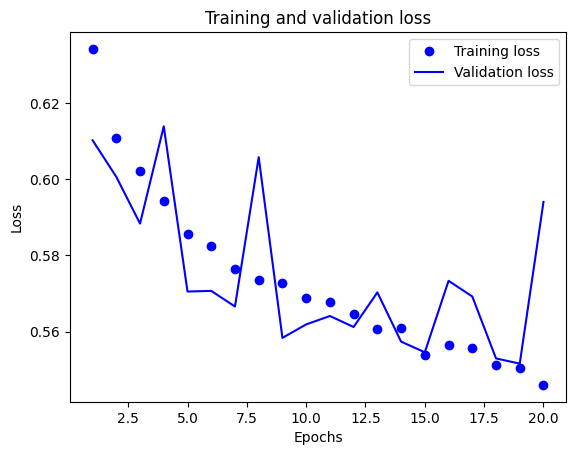

In [ ]:
visualize_performance(pre_history, flag = 'loss')

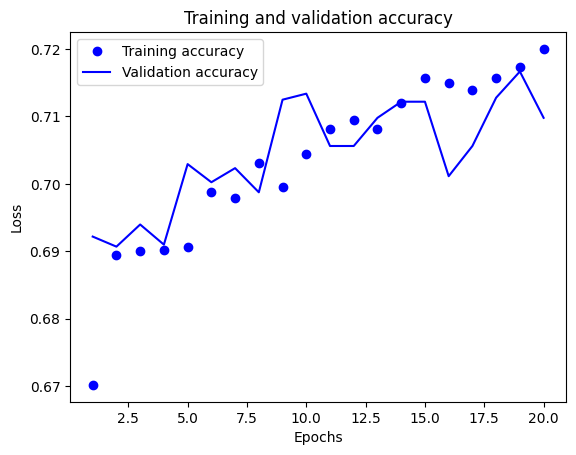

In [ ]:
visualize_performance(pre_history, flag = 'accuracy')

By using pre-trained model, the performance increased from 71.9 to 73.2%. However, the recall for 0 is extremely low (10%)


Analyzing the performance of the two models, we can look at it from several perspectives:

### Performance Comparison

1. **Accuracy**:
   - The self-trained embedding model (`eb_model`) has an accuracy of 0.719.
   - The pre-trained embedding model (`pre_model`) has an accuracy of 0.732.

   Using pre-trained GloVe embeddings slightly improves the model's accuracy. This suggests that pre-trained embeddings can provide richer semantic information, which helps enhance model performance.

2. **Precision, Recall, and F1 Score**:
   - For class 0 (minority class), the pre-trained embedding model shows significantly higher precision than the self-trained embedding model, but with a very low recall, resulting in a significantly reduced F1 score.
   - For class 1 (majority class), the performance of the two models is similar, but the pre-trained embedding model has a higher recall.

### Analysis and Interpretation

- **Impact of Class Imbalance**: Both models show a preference for the majority class (class 1), likely due to dataa imbalance. The pre-trained embedding model has an extremely low recall rate for class 0, indicating the model almost fails to correctly identify minority class samples. Despite a slightly higher overall accuracy, the pre-trained model performs poorly in balancing precision and recall, especially for the minority class.

- **Impact of Pre-trained Embeddings**: Although pre-trained embeddings help with overall accuracy, the disparity in recall highlights that the model might need further adjustments or different strategies to better handle class imbalance issues. The semantic information provided by pre-trained embeddings might make the model more adept at recognizing features of the more frequently occurring class 1, while neglecting features of class 0.


In comparing the traditional ML models I've applied in earlier assignments with the deep learning model using neural networks (NN) here, I've observed that while NNs provide a flexible framework for capturing complex patterns in data, they are also more prone to overfitting, especially when the training data is limited or when the network architecture is too complex. Surprisingly, the accuracy of NNs in my experiments was similar to, and in some cases slightly lower than, that of traditional ML models. This could be attributed to the robustness of traditional ML models like Random Forests or Support Vector Machines, which, despite their simplicity, often perform exceptionally well on structured data. These findings echo the concepts introduced in the lecture, emphasizing the trade-offs between model complexity and generalizability.

Conclusion: Classic RF model is more suitable in my task.
